In [1]:
import pandas as pd
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt
import warnings
import gc
import json

from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

warnings.simplefilter("ignore", UserWarning)

PATH = '/home/mglz/projects/master/stock_matching/data/'

# Load data

## Base

### Base dataset

In [2]:
scaler = StandardScaler()

In [3]:
df_base = pd.read_csv(PATH + 'base.csv', index_col=0)
df_base = pd.DataFrame(scaler.fit_transform(df_base), index=df_base.index)
#df_base.head()

### Create index with FAISS

In [4]:
dims = df_base.shape[1]
n_cells = 1000 # how many cells
n_neigbours = 30 # num of candidates
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = 200

**note that `n_neigbours` is set to 30 because lack of RAM on the local machine. Recommended value is >= 100*

In [5]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [6]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [7]:
with open(PATH + 'base_index.txt', 'w') as convert_file:
     convert_file.write(json.dumps(base_index))

## Train & Validation

### EDA

All features in datasets are unnamed columns and numbers so we do not khow what each of them means.

In [8]:
df_train = pd.read_csv(PATH + 'train.csv', index_col=0)
targets_train = df_train["Target"]
targets_valid = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)['Expected']

df_train.drop("Target", axis=1, inplace=True)
df_train = pd.DataFrame(scaler.transform(df_train), index=df_train.index)
df_valid = pd.read_csv(PATH + 'validation.csv', index_col=0)
df_valid = pd.DataFrame(scaler.transform(df_valid), index=df_valid.index)
#df_train


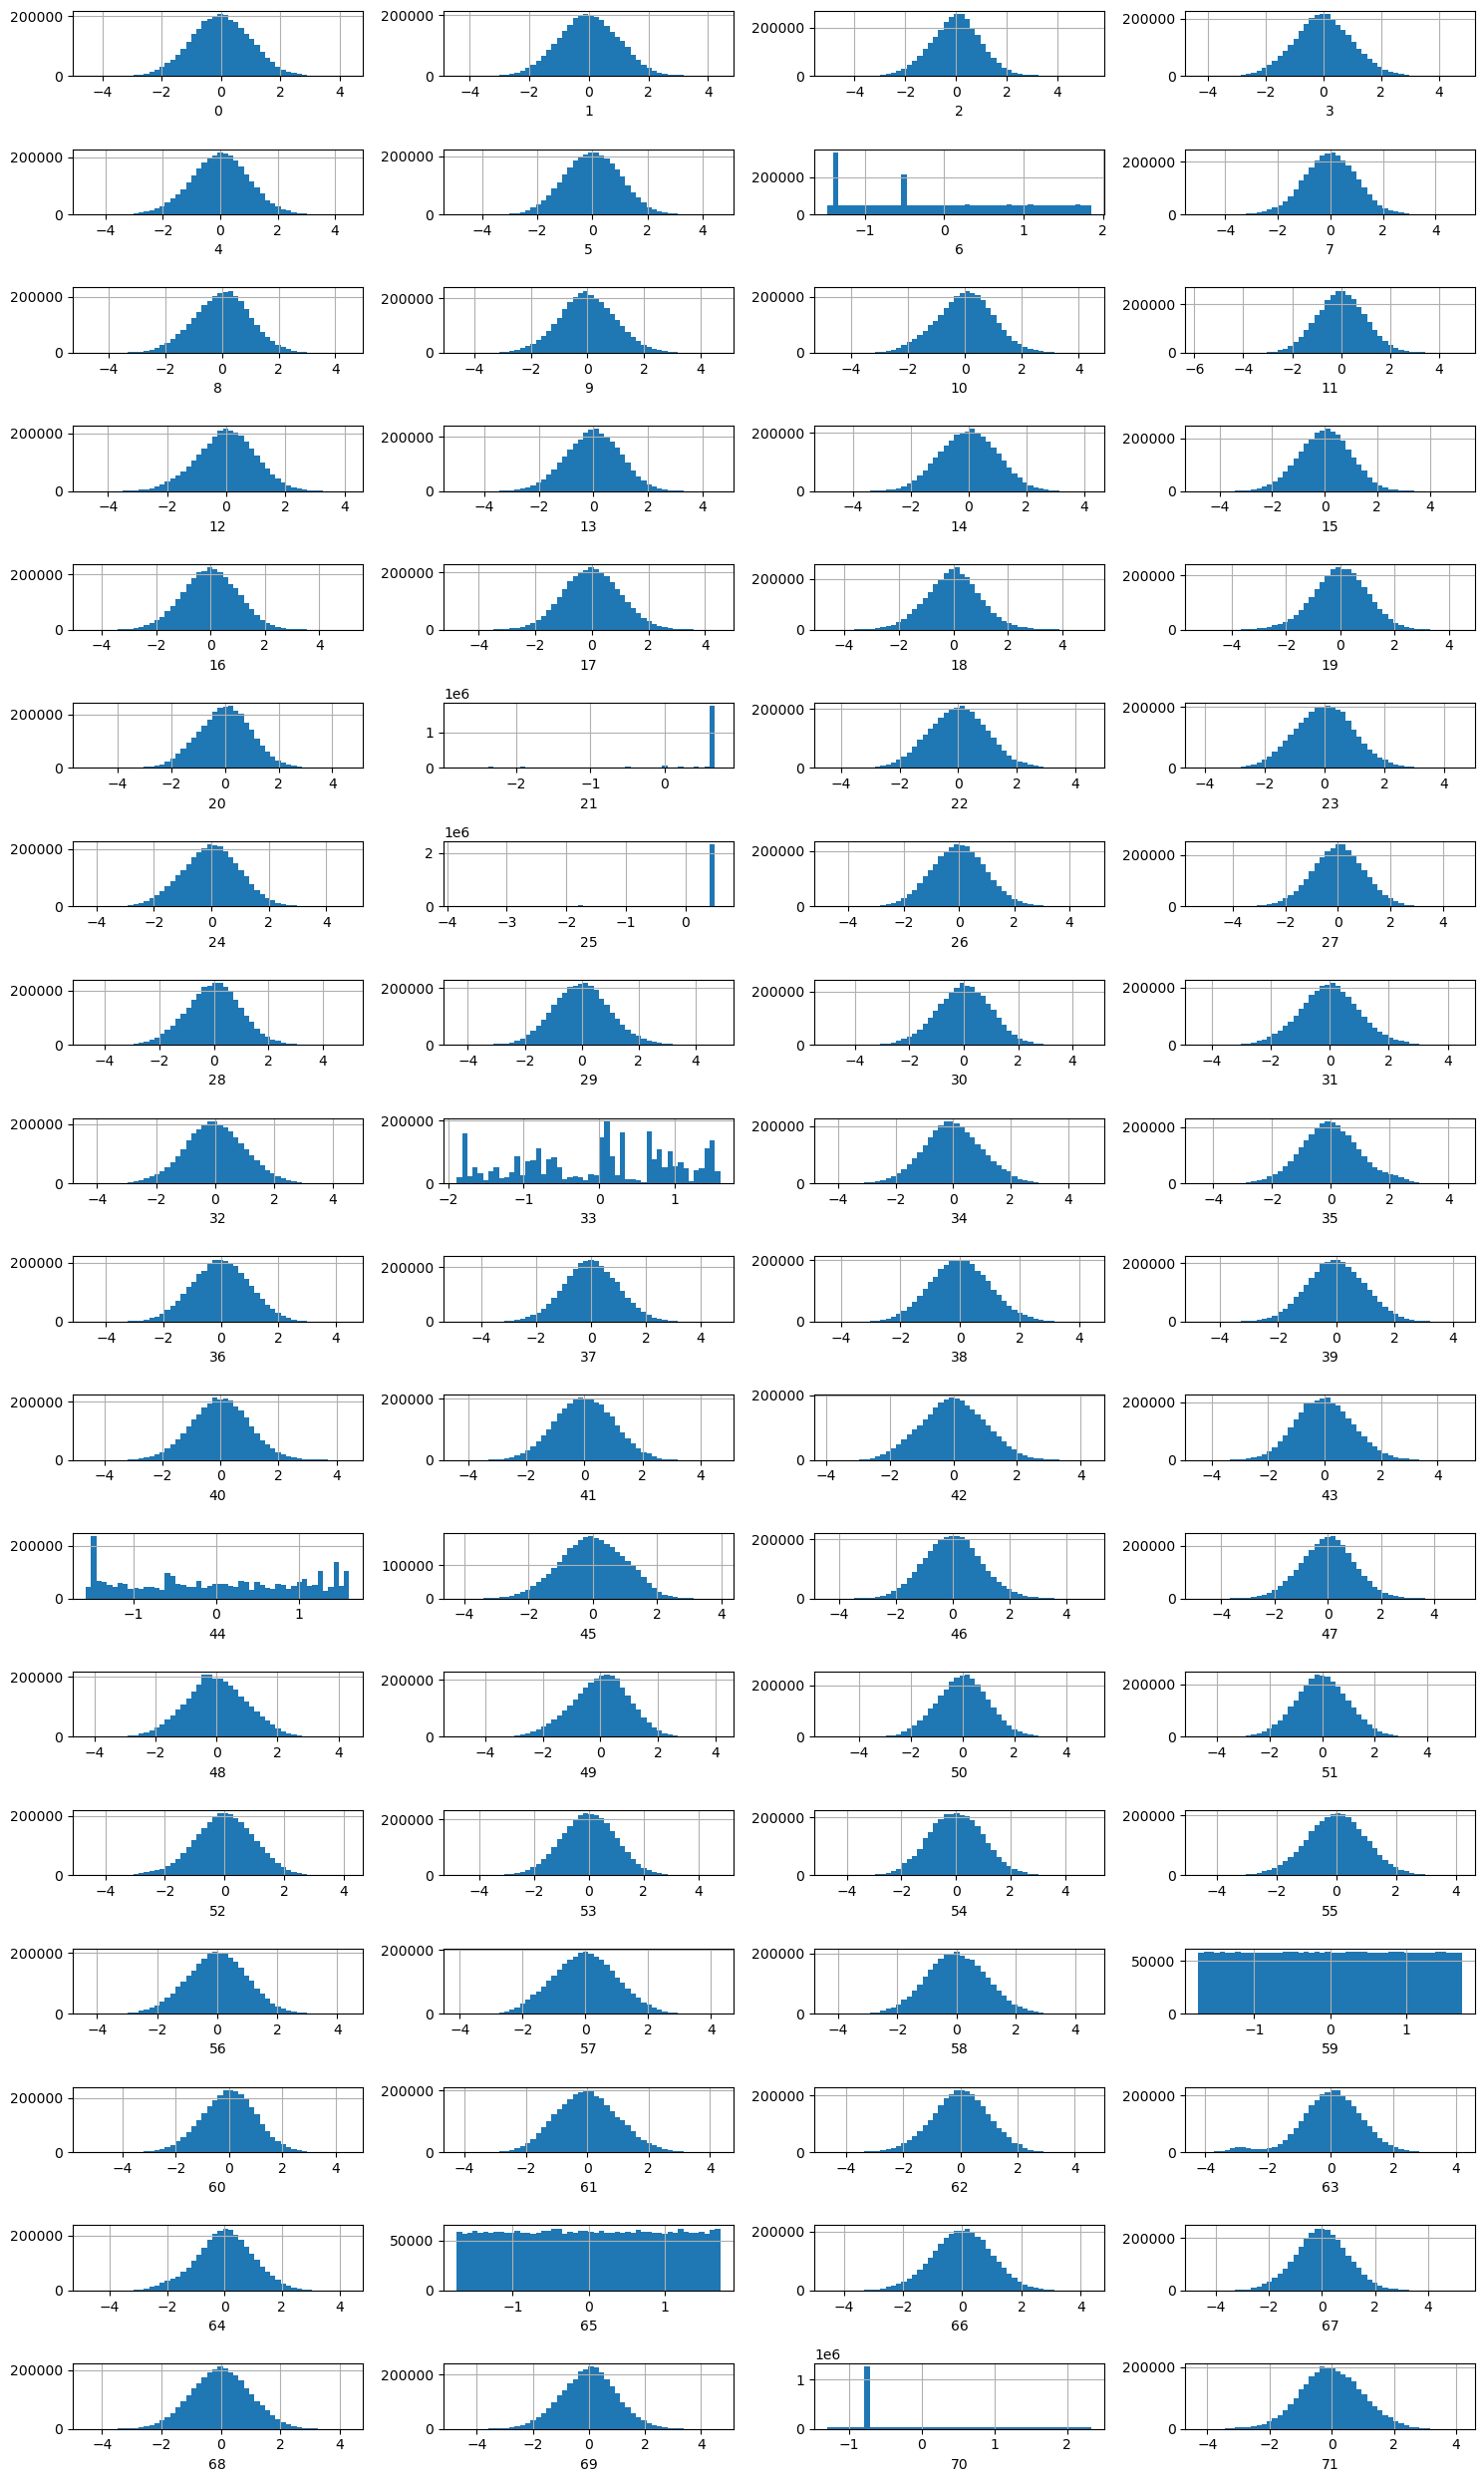

In [9]:
cols = df_train.columns

fig = plt.figure(figsize=(15,25))
for i in range(len(cols)):
    fig.add_subplot(18, 4, i+1)
    plt.hist(df_base[cols[i]], bins=50)
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);    

As seen in the graphs, there are some columns where the values are not  normally distributed. It seems that our vectors may be embeddings, so we can assume that these columns contain insignificant string values such as spaces, etc. Remove them later, to make the data preprocessing easier and improve metric values.

In [10]:
suspisious_cols = [6, 21, 25, 59, 65, 70]

### Searching candidates with FAISS

defining `candidate_search` function:

In [11]:
def candidate_search(df, df_target):
    start = time.time()
    distances, idx = idx_l2.search(np.ascontiguousarray(df.values).astype('float32'), n_neigbours)
    print('search took {}'.format(time.time() - start))
    
    acc = 0
    for target, el in zip(df_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])        
    print('neighbours found: {} %'.format(100 * acc / len(idx)))
    return distances, idx

Searching for `df_train`:

In [12]:
distances_train, idx_train = candidate_search(df_train, targets_train)

search took 656.1414241790771
neighbours found: 74.354 %


Searching for `df_valid`:

In [13]:
distances_valid, idx_valid = candidate_search(df_valid, targets_valid)

search took 652.7441127300262
neighbours found: 74.344 %


## Creating big `all-features` dataframes

defining `saving_big_df` function:

In [14]:
def saving_big_df(idx, distances, df, df_target, type):
    features_list = []
    target_list = []
    idx_d_list = []
    for i in tqdm(range(len(df))):
        q = [df[i] for index in idx[i]]
        p = [base[index] for index in idx[i]]
        d = [distance for distance in distances[i]]
        j = [index for index in idx[i]]
        t = np.array([1 if base_index[index] == df_target.values.tolist()[i] else 0 for index in idx[i]])
        target_list.append(t)
        features_list.append(np.concatenate((q, p), axis = 1)) 
        idx_d_list.append(np.vstack((j, d)).T)
        del q, p, t, j, d
                
    del df
    gc.collect()    
    print('lists created...')
    pd.DataFrame(np.concatenate(target_list)).to_csv(PATH + 'target_'+ type + '.csv')
    del target_list
    print('targets saved...')
    pd.DataFrame(np.concatenate(idx_d_list)).to_csv(PATH + 'faiss_idx_and_distances_'+ type + '.csv')
    del idx_d_list
    print('indexes ad distances saved...')
    pd.DataFrame(np.concatenate(features_list)).to_csv(PATH + 'all_features_'+ type + '.csv')
    del features_list
    print('features saved!')
    gc.collect()

In [15]:
base = np.array(df_base.reset_index(drop=True))
#train = np.array(df_train.drop(suspisious_cols, axis=1).reset_index(drop=True))
#valid = np.array(df_valid.drop(suspisious_cols, axis=1).reset_index(drop=True))
train = np.array(df_train)
valid = np.array(df_valid)

In [16]:
del df_base
del df_train
del df_valid
gc.collect()

0

### train `all-features` saving

In [17]:
saving_big_df(idx_train, distances_train, train, targets_train, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


### valid `all-features` saving

In [18]:
saving_big_df(idx_valid, distances_valid, valid, targets_valid, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


As mentioned, there is a lack of RAM on the local machine. For the possibility of further work, the second part is located in  `stock_matching_catboost_ranking.ipynb`

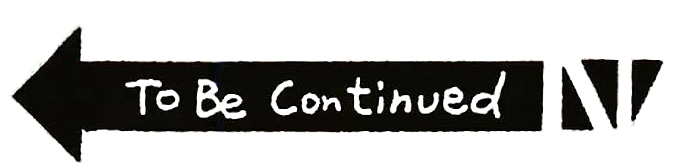